# Simulating and fitting multiple voxels with varying initial conditions

In [1]:
# load the necessary modules
from microstruktur.acquisition_scheme.acquisition_scheme import acquisition_scheme_from_bvalues
from microstruktur.signal_models import three_dimensional_models
from os.path import join
import numpy as np

acquisition_path = three_dimensional_models.GRADIENT_TABLES_PATH
bvalues_SI = np.loadtxt(join(acquisition_path, 'bvals_hcp_wu_minn.txt')) * 1e6  # in s/m^2
gradient_directions = np.loadtxt(join(acquisition_path, 'bvecs_hcp_wu_minn.txt'))  # on unit sphere
delta = 0.0106 # in seconds
Delta = 0.0431 # in seconds
acq_scheme = acquisition_scheme_from_bvalues(
    bvalues_SI, gradient_directions, delta, Delta)

For real applications, we may need to simulate data with many different initial conditions, or fit a real dataset where we want to give a voxel-dependent initial condition to avoid local minima. The toolbox allows you to do both these things by generating a multi-dimensional parameter_vector.

As an example, we will generate a simple Ball & Stick model.

In [2]:
stick = three_dimensional_models.I1Stick()
ball = three_dimensional_models.E3Ball()
ball_and_stick = (
    three_dimensional_models.PartialVolumeCombinedMicrostrukturModel(
        models=[ball, stick]))

Now say we want to simulate the signal in each voxel to have the same lambdas and partial_volume, but varying 10x10 grid of $\mu$. This can be done by giving parameters_to_parameter vector just the single value you want for the lambdas and partial_volume, but the mu as a 10x10x2 array.

In [3]:
lambda_par = np.random.rand() * 1e-9
lambda_iso = lambda_par / 2.
partial_volume = 0.4
mu_array = np.random.rand(10, 10, 2) * 2.

gt_parameter_vector = (
    ball_and_stick.parameters_to_parameter_vector(
        I1Stick_1_lambda_par=lambda_par,
        E3Ball_1_lambda_iso=lambda_iso,
        I1Stick_1_mu=mu_array,
        partial_volume_0=partial_volume)
)

#notice that the entire parameter array is now 10x10x5
print gt_parameter_vector.shape

(10, 10, 5)


In [4]:
# the data can now be generated exactly as before.
E_array = ball_and_stick.simulate_signal(acq_scheme, gt_parameter_vector)
print E_array.shape

(10, 10, 288)


In [5]:
single_parameter_vector = (
    ball_and_stick.parameters_to_parameter_vector(
        I1Stick_1_lambda_par=lambda_par,
        E3Ball_1_lambda_iso=lambda_iso,
        I1Stick_1_mu=(0, 0),
        partial_volume_0=partial_volume)
)
# I'm giving a either a single or voxel-dependent initial condition with gt_mu_array
res_single_x0 = ball_and_stick.fit(E_array, acq_scheme, single_parameter_vector)
res_voxel_dependent_x0 = ball_and_stick.fit(E_array, acq_scheme, gt_parameter_vector)

To illustrate the importance of giving good initial condition to the model, we plot the percentual error of the estimated model parameters compared to the ground truth:

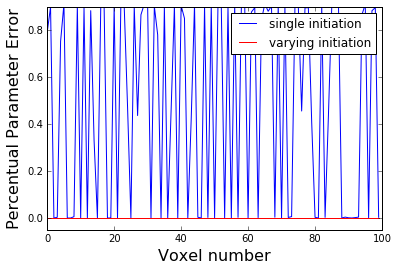

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline  

percentual_error_single = np.mean(
    ((abs(gt_parameter_vector - res_single_x0)) / gt_parameter_vector), axis=-1)
percentual_error_varying = np.mean(
    ((abs(gt_parameter_vector - res_voxel_dependent_x0)) / gt_parameter_vector), axis=-1)

plt.plot(percentual_error_single.ravel(), c='b', label='single initiation')
plt.ylim(-.05, .9)
plt.plot(percentual_error_varying.ravel(), c='r', label='varying initiation')
plt.legend()
plt.ylabel('Percentual Parameter Error', fontsize=16)
plt.xlabel('Voxel number', fontsize=16)

The results using varying initial condition (using the ground truth in this case) unsurprisingly always results in the optimal solution, and using the same initiation often results in a local minimum.

When fitting real data, one way to avoid local minima for complicated models is to pre-estimate some of the easier model parameter with simpler models. For example, a good initialization for model orientation $\mu$ could be estimated using DTI. We'll show this in the next tutorial.